# Predicting no-show patients at a Dental Practice

## Introduction

### Goal
To document steps used to create a machine learning algorithm that predicts patient attendance.

### Steps

1) Feature Engineering

2) Building ML model

3) Hyperparameter Tuning

4) Visualizing model output





## 1) Automatic Feature Creation using featuretools

In [1]:
import featuretools as ft
import featuretools.variable_types as vtypes
import pandas as pd
import os
import multiprocess as mp

# Load the model from disk
weather = pickle.load(open('data/weather2018.pkl', 'rb'))

#read current working directory
##assume running notebook from No_show_patience directory
cwd = os.getcwd()


#import and load data
full_dataset = pd.read_pickle(cwd + "/data/preFT2018.pkl")
#use below code at experimentation stage to build new features on a small dataset.
#full_dataset = full_dataset.iloc[:5,:]

full_dataset.AppointmentDate = (pd.to_datetime(full_dataset.AppointmentDate) + 
                                (pd.Timedelta(days = 1) - pd.Timedelta(seconds = 1)) * (full_dataset.noshow))



variable_types = {'PatientId': vtypes.Numeric, 'newbie':vtypes.Boolean,'insuranceDummy':vtypes.Boolean, 
                  'guarantorIsPatient':vtypes.Boolean, 'loyalty':vtypes.Numeric, 'noshow':vtypes.Boolean, 
                  'PatientEmail':vtypes.EmailAddress,'GuarantorEmail':vtypes.EmailAddress,
                  'PatientPhone1':vtypes.PhoneNumber, 'patientEmailDomain':vtypes.Categorical,
                  'guarantorEmailDomain':vtypes.Categorical, 'patientPhone1AreaCode':vtypes.Categorical, 
                  'insurance':vtypes.Categorical, 'provider':vtypes.Categorical, 
                  'source':vtypes.Categorical, 'procedure':vtypes.Categorical,
                  'weekday':vtypes.Categorical, 'apptType':vtypes.Categorical,
                  "newpatientfile":vtypes.Ordinal, "Age_npf":vtypes.Numeric, "Patient":vtypes.Text}
variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId'])

In [2]:
full_dataset[variable_list].iloc[0:9,:].to_csv(cwd + "/data/head.csv")

In [2]:
# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=full_dataset[variable_list],
                              index='AppointmentId',
                              time_index='AppointmentDate',
                              variable_types=variable_types)
es['appointments']

# Make patients, weekdays, emails and insurances entities

es.normalize_entity(base_entity_id='appointments', new_entity_id='patients', index='PatientId', 
                    additional_variables = ['Patient', 'PatientEmail', 'GuarantorEmail', 'PatientPhone1',
                                            'newpatientfile', 'Age_npf'], make_time_index=True)
# 'PatientEmail', 'GuarantorEmail', 'PatientPhone1'
es.normalize_entity('appointments', 'patientemails', 'patientEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'guarantoremails', 'guarantorEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'patientPhones', 'patientPhone1AreaCode',make_time_index=True)
es.normalize_entity('appointments', 'insurances', 'insurance',make_time_index=True)
es.normalize_entity('appointments', 'providers', 'provider', make_time_index=True)
es.normalize_entity('appointments', 'sources', 'source', make_time_index=True)
es.normalize_entity('appointments', 'procedures', 'procedure', make_time_index=True)
es.normalize_entity('appointments', 'weekdays', 'weekday', make_time_index=True)
es.normalize_entity('appointments', 'apptTypes', 'apptType',make_time_index=True)

variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 'insurance',
                  'provider', 'procedure', 'weekday', 'apptType', 'AppointmentId'])

In [3]:
print(es)

Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 17]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [11]:
cutoff_times =  es['appointments'].df[['AppointmentId','AppointmentDate']]
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']

X_ft, features = ft.dfs(entityset=es,
                        target_entity='appointments',
                        agg_primitives=['count', 'percent_true', 'num_true', 'trend', 'skew', 'all', 'std',
                                       'max', 'mean', 'min', 'median', 'num_unique'],
                        max_depth=3,
                        trans_primitives=['day', 'month', 'year', 'num_words', 'num_characters'],
                        cutoff_time=cutoff_times,
                        verbose=True,
                        approximate = '3h',
                        #approximate = "1 day",
                        chunk_size=50,
                        n_jobs=mp.cpu_count())

Built 372 features
EntitySet scattered to 4 workers in 5 seconds           
Elapsed: 21:05 | Progress: 100%|██████████| Remaining: 00:00  


In [12]:
X_ft.head()

,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,noshow,patientEmailDomain,guarantorEmailDomain,patientPhone1AreaCode,insurance,...,sources.NUM_UNIQUE(appointments.YEAR(AppointmentDate)),procedures.NUM_UNIQUE(appointments.DAY(AppointmentDate)),procedures.NUM_UNIQUE(appointments.MONTH(AppointmentDate)),procedures.NUM_UNIQUE(appointments.YEAR(AppointmentDate)),weekdays.NUM_UNIQUE(appointments.DAY(AppointmentDate)),weekdays.NUM_UNIQUE(appointments.MONTH(AppointmentDate)),weekdays.NUM_UNIQUE(appointments.YEAR(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.DAY(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.MONTH(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.YEAR(AppointmentDate))
AppointmentId,,,,,,,,,,,,,,,,,,,,,
319,9608,0,0,True,19,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_434,Insurance_others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526,9393,0,0,True,10,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,Insurance_others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4249,9200,0,1,True,24,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_others,Insurance_UNITED CONCORDIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,8562,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,Insurance_others,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1942,9961,0,0,True,19,0,PatientEmail_GMAIL.COM,GuarantorEmail_GMAIL.COM,PatientPhone1_540,Insurance_others,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


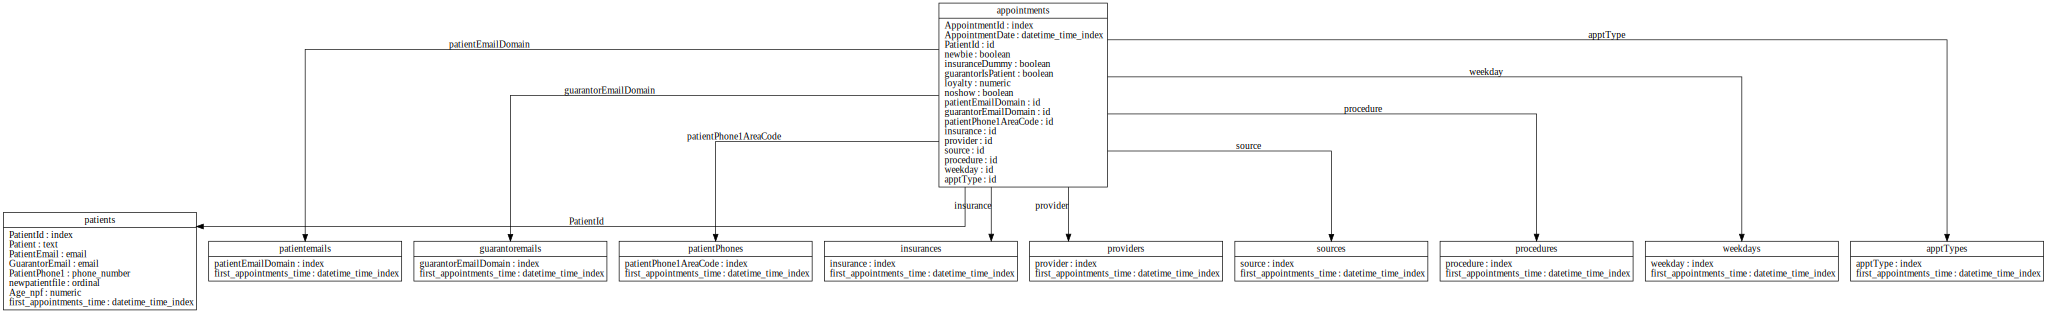

In [14]:
es.plot()

## 2) Building ML models

In [4]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
import pandas as pd
import numpy as np
import multiprocess as mp
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import os

cwd = os.getcwd()

In [5]:
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']


In [6]:
#pickle that data set. only do this when you want to replace
#X_ft.drop(cat_cols,axis=1).to_pickle(cwd + "/data/postFT_insight.pkl")
full_dataset = pd.read_pickle(cwd + "/data/postFT_insight.pkl")

In [6]:
##skip this step if loading in pickle
##choose to drop cat cols
#cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
#            'patientPhone1AreaCode','weekday', 'apptType','source']


#import and load data
#full_dataset = pd.concat([X_ft],axis=1).drop(cat_cols,axis=1)

In [7]:
##if loading pickle, drop in here
X = full_dataset.drop(['noshow'],axis=1)
y = full_dataset[['noshow']]


In [8]:
#split 2018 data into training and test sets, setting a seed for replication purposes
cutoff_month = 8
X_train, X_test, y_train, y_test = (X[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    X[X['MONTH(AppointmentDate)']>cutoff_month],
                                    y[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    y[X['MONTH(AppointmentDate)']>cutoff_month])


# Explicitly impute values for missing fields for RF and Log
X_train, X_test = X_train.fillna(X_train.mean()), X_test.fillna(X_test.mean())
X_train, X_test = X_train.fillna(0), X_test.fillna(0)



In [9]:
#logistic regression model
model_log = LogisticRegression(solver="liblinear", C=0.5, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_log = model_log.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
from sklearn.ensemble import RandomForestClassifier
#random forest model
model_rf = RandomForestClassifier(n_estimators=1000, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_rf = model_rf.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
##XGBoost
from xgboost import XGBClassifier, plot_importance

#XGB - automatically deals with missing values during training
model_xgb = (XGBClassifier(n_estimators=1914, max_depth = 25, eta = 0.15076, subsample = 0.62141, 
                           n_thread = 4, random_state=1, alpha = 0,
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb = model_xgb.predict_proba(X_test)

In [12]:
print("The AUC score of the Log Reg model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_log)[1]),2)))
print("The AUC score of the RF model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_rf)[1]),2)))
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))


The AUC score of the Log Reg model is: 0.59
The AUC score of the RF model is: 0.62
The AUC score of the XGB model is: 0.64


### 3) Hyperparameter Tuning

#### alpha 

In [55]:
#alpha rate
param_test1 = {'alpha':[0, 1e-2, 0.1, 1, 10, 100, 1000]}

gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 4, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0.5,tree_method = 'hist'),
                        cv=5, param_grid = param_test1, scoring='roc_auc', iid=False)

gsearch1.fit(X_train,y_train.values.ravel())
gsearch1.best_params_, gsearch1.best_score_
##alpha of 0 is best

({'alpha': 0}, 0.37458892581974357)

#### max depth

In [56]:
#max depth
param_test2 = {'max_depth':range(5,45,10)}

gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test2, scoring='roc_auc', iid=False)

gsearch2.fit(X_train,y_train.values.ravel())
gsearch2.best_params_, gsearch2.best_score_



({'max_depth': 5}, 0.365290563677373)

In [59]:
#max depth fine tune
param_test3 = {'max_depth':[1,2,3,4,5,6]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test3, scoring='roc_auc', iid=False)

gsearch3.fit(X_train,y_train.values.ravel())
gsearch3.best_params_, gsearch3.best_score_



({'max_depth': 2}, 0.39912281793866244)

#### max estimators

In [ ]:
#n_estimators
param_test4 = {'n_estimators':range(200,1000,200)}

gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test4, scoring='roc_auc', iid=False)

gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_


In [70]:
#n_estimators
param_test4 = {'n_estimators':[6,12,25, 50, 100,200]}

gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test4, scoring='roc_auc', iid=False)

gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_

({'n_estimators': 12}, 0.4792200464550894)

#### eta

In [64]:
#eta
param_test5 = {'eta':[i/20.0 for i in range(1,6)]}

gsearch5 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test5, scoring='roc_auc', iid=False)

gsearch5.fit(X_train,y_train.values.ravel())
gsearch5.best_params_, gsearch5.best_score_


({'eta': 0.05}, 0.39912281793866244)

#### subsample

In [66]:
#subsample
param_test6 = {'subsample':[i/10.0 for i in range(1,9,2)]}

gsearch6 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test6, scoring='roc_auc', iid=False)

gsearch6.fit(X_train,y_train.values.ravel())
gsearch6.best_params_, gsearch6.best_score_


({'subsample': 0.3}, 0.3731401835583753)

#### gamma

In [67]:
#gamma rate
param_test7 = {'gamma':[i/10.0 for i in range(0,5)]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring='roc_auc', iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_


({'gamma': 0.1}, 0.37108066572634374)

In [68]:
#gamma rate
param_test7 = {'gamma':[i/20.0 for i in range(0,3)]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring='roc_auc', iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_

({'gamma': 0.1}, 0.37108066572634374)

#### all together

In [73]:
param_test8 = {'gamma':[i/20.0 for i in range(0,3)],
               'max_depth':[1,2,3,4,5,6],
               'n_estimators':[6,12,25, 50, 100],
               'eta':[i/20.0 for i in range(1,4)],
               'subsample':[i/10.0 for i in range(1,9,2)],
              }

gsearch8 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test8, scoring='roc_auc', iid=False)


gsearch8.fit(X_train,y_train.values.ravel())
gsearch8.best_params_, gsearch8.best_score_

({'eta': 0.05,
  'gamma': 0.0,
  'max_depth': 1,
  'n_estimators': 25,
  'subsample': 0.5},
 0.582821084090225)

In [74]:
##XGBoost with updated stuff
from xgboost import XGBClassifier, plot_importance

#XGB - automatically deals with missing values during training
model_xgb_PT = (XGBClassifier(n_estimators=25, max_depth = 1, eta = 0.05, subsample = 0.5, 
                           n_thread = 4, random_state=1, alpha = 0,gamma = 0.0,
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb_PT = model_xgb_PT.predict_proba(X_test)
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1]),2)))


The AUC score of the XGB model is: 0.67


### 4) Visualizing Model 


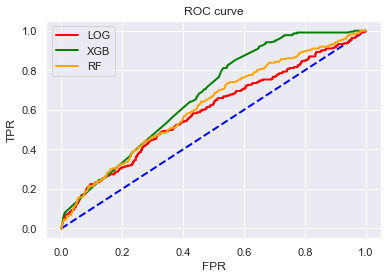

In [76]:
##comparing LOG, XGB, RF

import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

##calculate false positive and true positive rates
fpr, tpr,_=roc_curve(y_test,pd.DataFrame(y_pred_model_log)[1],drop_intermediate=False)
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_3, tpr_3,_=roc_curve(y_test,pd.DataFrame(y_pred_model_rf)[1],drop_intermediate=False)


# plot ROC and reference
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='red', lw=2, label='LOG')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB')
plt.plot(fpr_3, tpr_3, color='orange', lw=2, label='RF')

##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_ROCcurve.png')
plt.show()

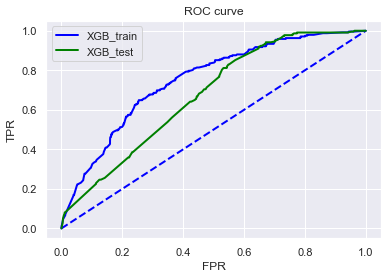

In [77]:
import matplotlib.pyplot as plt

y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)

##comparing ROC for XGB train and test
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_train, tpr_train,_=roc_curve(y_train,pd.DataFrame(y_pred_model_xgb_train)[1],drop_intermediate=False)


plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='XGB_train')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB_test')


##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')


plt.savefig(cwd + '/data/test_vs_train.png')
plt.show()

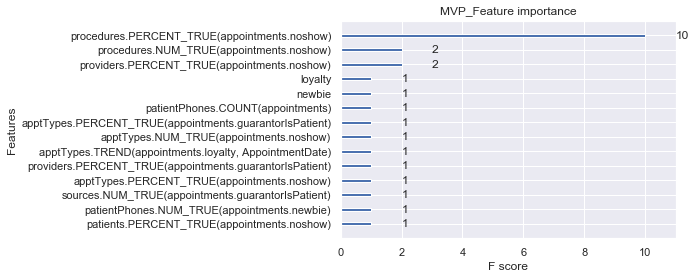

In [79]:
fig, ax = plt.subplots() #figsize=(10, 200)
plot_importance(model_xgb_PT, ax=ax)
plt.title('MVP_Feature importance')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_Feature_importance.png')
plt.show()

#### percentage vs no show

In [81]:
y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)
train_percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_train[:,1]})

In [82]:
##are all indexes the same
same_index = y_train.index == X_train.index
same_index.all()

True

In [83]:
#sanity check. where to call it no shows?
table = pd.concat([X_train['PatientId'].reset_index(drop=True), y_train.reset_index(drop=True), train_percent_noshow.reset_index(drop=True)], axis=1)
table

,PatientId,noshow,percent_noshow
0,9608,0,0.071677
1,9393,0,0.071677
2,9200,0,0.071677
3,8562,0,0.066727
4,9961,0,0.064173
...,...,...,...
3656,7685,0,0.121665
3657,4515,0,0.137683
3658,6830,0,0.148194
3659,1390,1,0.137683


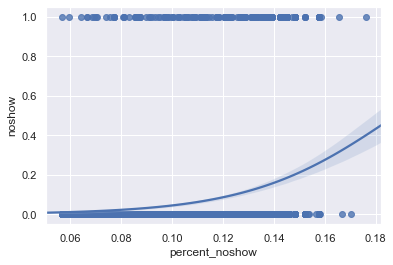

In [84]:
##training data
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=table)
fig = ax.get_figure()
fig.savefig("percent_noshow_logistic.png")

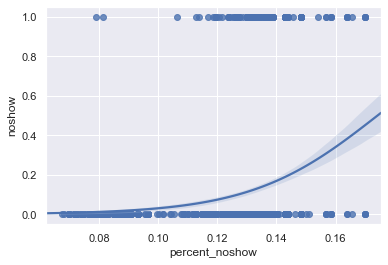

In [85]:
##test_data
percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_PT[:,1]})
test_table = pd.concat([X_test['PatientId'].reset_index(drop=True), y_test.reset_index(drop=True), percent_noshow.reset_index(drop=True)], axis=1)

test_logistic = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=test_table)
test_logistic = test_logistic.get_figure()
test_logistic.savefig("percent_noshow_logistic_test.png")

In [95]:
no_show_likely = test_table[test_table['percent_noshow']>0.14]
pd.crosstab(no_show_likely.noshow, no_show_likely.percent_noshow)

percent_noshow,0.140144,0.140937,0.142717,0.142796,0.142999,0.143996,0.145711,0.146255,0.148194,0.149853,0.150987,0.153924,0.156724,0.158358,0.164004,0.165437,0.170136
noshow,,,,,,,,,,,,,,,,,
0,4,1,122,20,8,18,0,1,160,1,1,0,4,5,2,1,5
1,0,0,23,2,0,4,1,0,32,0,0,1,2,4,5,1,5


In [89]:
test_table['percent_noshow']>0.6

0       False
1       False
2       False
3       False
4       False
        ...  
1805    False
1806    False
1807    False
1808    False
1809    False
Name: percent_noshow, Length: 1810, dtype: bool

In [80]:
#storing the pickled model. 
import pickle
#pickle model, code from Lindsay
# My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
# Don't change anything else unless you really want to.
#with open('insightMVP_model.pkl', 'wb') as fid:
    #pickle.dump(model_xgb_PT, fid,2)  


In [ ]:

# Load the model from disk
loaded_model = pickle.load(open('insightMVP_model.pkl', 'rb'))



y_pred_model_xgb = loaded_model.predict_proba(X_test)

print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))